In [69]:

from Weather.Laplace_inter import interpolate_laplace
import startinpy
import rasterio
from pathlib import Path
import re
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import pandas as pd
import numpy as np
import contextily as ctx
import os

In [70]:
# List of (filename, float value to add)
files_info = [
    ("selection_34", 34.0),
    ("selection_50", 50.0),
    ("selection_64", 64.0)
]
# List to store the individual GeoDataFrames
gdf_list = []
for fname, val in files_info:
    # Load shapefile
    gdf = gpd.read_file(f"./Miami/{fname}.shp")
    # Add new column with float value from filename
    gdf["selection_value"] = val
    # Append to list
    gdf_list.append(gdf)
# Concatenate all GeoDataFrames into one
combined_gdf = gpd.GeoDataFrame(pd.concat(gdf_list, ignore_index=True), crs=gdf_list[0].crs)


In [71]:
# Ensure PWIND120 is numeric
combined_gdf["PWIND120"] = pd.to_numeric(combined_gdf["PWIND120"], errors="coerce")

# Group by date and geometry (or point ID if available)
def select_row(group):
    # Filter for candidates with PWIND120 > 0.25
    valid = group[group["PWIND120"] > 25]
    
    if not valid.empty:
        # Among valid ones, choose the one with the highest selection_value
        idx = valid["selection_value"].idxmax()
        return group.loc[idx]
    else:
        # If none valid, fallback to the row with highest PWIND120
        idx = group["PWIND120"].idxmax()
        return group.loc[idx]

# Apply the selection logic to each group
selected_rows = combined_gdf.groupby(["date", "geometry"]).apply(select_row)
# Reset index after groupby
selected_rows = selected_rows.reset_index(drop=True)

C:\Users\roelo\AppData\Local\Temp\ipykernel_25072\2410895153.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  selected_rows = combined_gdf.groupby(["date", "geometry"]).apply(select_row)


In [ ]:
def agent_init_data(state, county):
    """
    Initialize agent data for a specific state and county by processing census data.
    
    Loads existing processed data if available, otherwise processes raw census data
    including education, demographics, and population density calculations.
    
    Args:
        state (list): List of state names
        county (list): List of county names
    
    Returns:
        GeoDataFrame: Processed census data for the specified location
    """

    # Check if processed data already exists
    data_path = f"../ACSDATA/{state}{county}"
    if os.path.isdir(data_path):
        return gpd.read_file(f"{data_path}/data.gpkg", layer='Data')

    # Load and process raw census data
    final_gdf = gpd.read_file("../ACSDATA/ASC_data.gpkg", layer='Data')

    # Combine education columns (7-14) into single "some_highschool" column
    some_highschool = final_gdf[final_gdf.columns[7:14]].sum(1)
    final_gdf = final_gdf.drop(columns=final_gdf.columns[7:14])
    final_gdf.insert(7, "some_highschool", some_highschool)

    # Filter data for specified state and county
    gdf_AOI = final_gdf[final_gdf["County"].isin(county)]
    gdf_AOI = gdf_AOI[gdf_AOI["State"].isin(state)]

    # Remove rows with zero totals in demographic groupings
    demographic_groups = [[6, 16], [17, 33], [34, 53], [55, 70]]  # Education, Race, Age, Income
    indexes_to_remove = []
    for group in demographic_groups:
        group_sum = gdf_AOI[gdf_AOI.columns[group[0]:group[1]]].sum(axis=1)
        zero_in_series = group_sum[group_sum == 0]
        indexes_to_remove.extend(zero_in_series.index)

    df_cleaned = gdf_AOI.drop(set(indexes_to_remove))

    # Calculate proportions within each demographic group
    for group in demographic_groups:
        group_sum = df_cleaned[df_cleaned.columns[group[0]:group[1]]].sum(axis=1)
        df_cleaned[df_cleaned.columns[group[0]:group[1]]] = df_cleaned[
            df_cleaned.columns[group[0]:group[1]]].div(group_sum, axis=0)
        print(df_cleaned[df_cleaned.columns[group[0]:group[1]]].sum(axis=1))

    # Calculate population density as proportion of total population
    df_cleaned["PopDense"] = df_cleaned["AgeTotal"] / df_cleaned["AgeTotal"].sum()
    print(f"Population density sum check: {df_cleaned['PopDense'].sum()}")

    # Save processed data
    os.makedirs(data_path)
    df_cleaned.to_file(f"{data_path}/data.gpkg", driver='GPKG', layer='Data')

    return df_cleaned

In [1]:
# Create the full 6-hourly time range
time_range = pd.date_range(start='2017-09-3 00:00:00', end='2017-09-10 23:59:00', freq='6h')
# Get unique geometries
unique_geometries = selected_rows['geometry'].unique()
# Create a MultiIndex of all geometry x datetime combinations
full_index = pd.MultiIndex.from_product([unique_geometries, time_range], names=["geometry", "date"])

# Set index on original GeoDataFrame
gdf_indexed = selected_rows.set_index(['geometry', 'date'])
# Reindex with the full index to add missing rows
gdf_full = gdf_indexed.reindex(full_index)
gdf_full['PWIND120'] = -1  # Default value
gdf_full['selection_value'] = 10
# Fill in values where available in the original
for idx in gdf_indexed.index:
    if idx in gdf_full.index:
        gdf_full.loc[idx] = gdf_indexed.loc[idx]
gdf_full =gpd.GeoDataFrame(gdf_full.reset_index(), geometry= "geometry",crs=4326)

NameError: name 'pd' is not defined

In [ ]:
# Load census tract data for Miami-Dade County, Florida
init_df = agent_init_data(["Florida"], ["Miami-Dade County"])

# Calculate centroids of census tracts and convert to WGS84 coordinates
tract_centers = init_df["geometry"].centroid.to_crs(4326)

# Initialize dictionary to store interpolated wind values for each census tract
tract_dict = dict(zip(init_df['NAME'], [[] for i in range(len(init_df['NAME']))]))

# Iterate through each unique timestamp in the wind data
for t in gdf_full["date"].unique():
    # Filter data for current timestamp
    t_df = gdf_full[gdf_full["date"] == t]

    # Convert wind measurement points to WGS84 coordinates
    poly = t_df["geometry"].to_crs(3857).centroid.to_crs(4326)

    # Create array of points with their wind values for triangulation
    pts = np.vstack((poly.x.to_list(), poly.y.to_list(), t_df["selection_value"])).transpose()

    # Initialize Delaunay triangulation
    dt = startinpy.DT()
    dt.insert(pts)

    # Interpolate wind values at each census tract centroid
    for index, center in enumerate(tract_centers):
        tract_dict[list(tract_dict.keys())[index]].append(interpolate_laplace(dt, center.x, center.y))

# Add interpolated wind values as new column to census tract dataframe
init_df['wind'] = init_df['NAME'].map(tract_dict)


In [ ]:
def wind_float_to_cat(windvalue):
    """
    Convert wind speed values to categorical values between 0 and 1.
    Categories based on Beaufort scale and hurricane wind speeds:
    - Below 34 knots: Gentle breeze (0.0)
    - 34-40 knots: Gale (0.2)
    - 40-47 knots: Strong Gale (0.4)
    - 47-55 knots: Storm (0.6)
    - 55-63 knots: Violent Storm (0.8)
    - Above 63 knots: Hurricane (1.0)
    """
    if windvalue < 34:
        return 0  # Gentle breeze
    elif windvalue >= 34 and windvalue < 40:
        return 0.2  # Gale
    elif windvalue >= 40 and windvalue < 47:
        return 0.4  # Strong Gale
    elif windvalue >= 47 and windvalue < 55:
        return 0.6  # Storm
    elif windvalue >= 55 and windvalue < 63:
        return 0.8  # Violent Storm
    elif windvalue > 63:
        return 1  # Hurricane


# Convert wind speeds to categories for each location's time series
WindCat =[list(map(wind_float_to_cat,row)) for row in init_df['wind']]
init_df['WindCat'] =WindCat

In [80]:
# --- Paths ---
base_folder = Path("../RainData/Miami")  # Base directory where all folders are stored
# Load points data
# init_df = gpd.read_file(points_fp)
coords = [(point.x, point.y) for point in tract_centers]
# Define timestamps to look for (every 2 hours)
target_times = {f"{h:02}0000" for h in range(0, 24, 2)}  # {'000000', '020000', ..., '220000'}
# Regex to match time in the filename
pattern = re.compile(r"-S(\d{6})")
# List to collect all results
all_data = []
# Loop over the folders from 16aug to 26aug (adjust folder names as needed)
for day_folder in range(3, 11):
    if len(str(day_folder))==1:
        day_folder = "0"+str(day_folder)# From 16 to 26
    date_str = f"{day_folder}sep"  # e.g., 16aug, 17aug, ..., 26aug
    day_folder_path = base_folder / date_str  # Path to the day's folder
    if not day_folder_path.exists():
        continue  # Skip if the folder doesn't exist

    # Get the .tif files from the folder
    selected_files = [
        tif for tif in day_folder_path.glob("*.tif")
        if (match := pattern.search(tif.name)) and match.group(1) in target_times]
    # Extract pixel values from each .tif for each point
    for tif in sorted(selected_files):
        with rasterio.open(tif) as src:
            samples = list(src.sample(coords))  # get pixel values
            timestamp = pattern.search(tif.name).group(1)
            # Add the date to the timestamp (format: yyyy-mm-dd hhmmss)
            full_timestamp = f"2017-{date_str[:2]}-{date_str[2:]} {timestamp[:2]}:{timestamp[2:4]}:{timestamp[4:]}"

            # Collect data with the correct point names from init_df["NAME"]
            point_names = init_df["NAME"].tolist()
            day_data = {
                "timestamp": full_timestamp,
                **{name: val[0] for name, val in zip(point_names, samples)}
            }
            all_data.append(day_data)

# Convert to DataFrame
df = pd.DataFrame(all_data)

rain_dict = df.drop(columns="timestamp").to_dict(orient='list')
init_df['rain'] = init_df['NAME'].map(rain_dict)

In [82]:
def rain_float_to_cat(rainvalue):
    """
    Convert rain intensity values (in mm/h) to categorical values between 0 and 1.
    Categories based on standard meteorological rain intensity scale:
    - 0 mm/h: No rain (0.0)
    - 0-2.5 mm/h: Light rain (0.2)
    - 2.5-7.5 mm/h: Moderate rain (0.4)
    - 7.5-15 mm/h: Heavy rain (0.6)
    - 15-30 mm/h: Intense rain (0.8)
    - >30 mm/h: Torrential rain (1.0)
    """
    if rainvalue == 0:
        return 0  # No rain
    if rainvalue < 2.5:
        return 0.2  # Light rain
    elif rainvalue >= 2.5 and rainvalue < 7.5:
        return 0.4  # Moderate rain
    elif rainvalue >= 7.5 and rainvalue < 15:
        return 0.6  # Heavy rain
    elif rainvalue >= 15 and rainvalue < 30:
        return 0.8  # Intense rain
    elif rainvalue >= 30:
        return 1  # Torrential rain


# Convert rain intensities to categories for each location's time series
RainCat = [list(map(rain_float_to_cat, row)) for row in init_df['rain']]
init_df['RainCat'] = RainCat

# Save the updated GeoDataFrame with rain categories to file
init_df.to_file(f"../ACSDATA/['Florida']['Miami-Dade County']/data.gpkg", driver='GPKG', layer='Data')

In [ ]:
# all = max_wind_gdf[["date","selection_value"]].groupby(by=["date"]).mean()
fig,ax = plt.subplots(figsize=[10,10])
ax.tick_params(axis='x', rotation=90)
sns.lineplot(x=gdf_full["date"],y=gdf_full["selection_value"])

In [ ]:
tract_centers.plot()

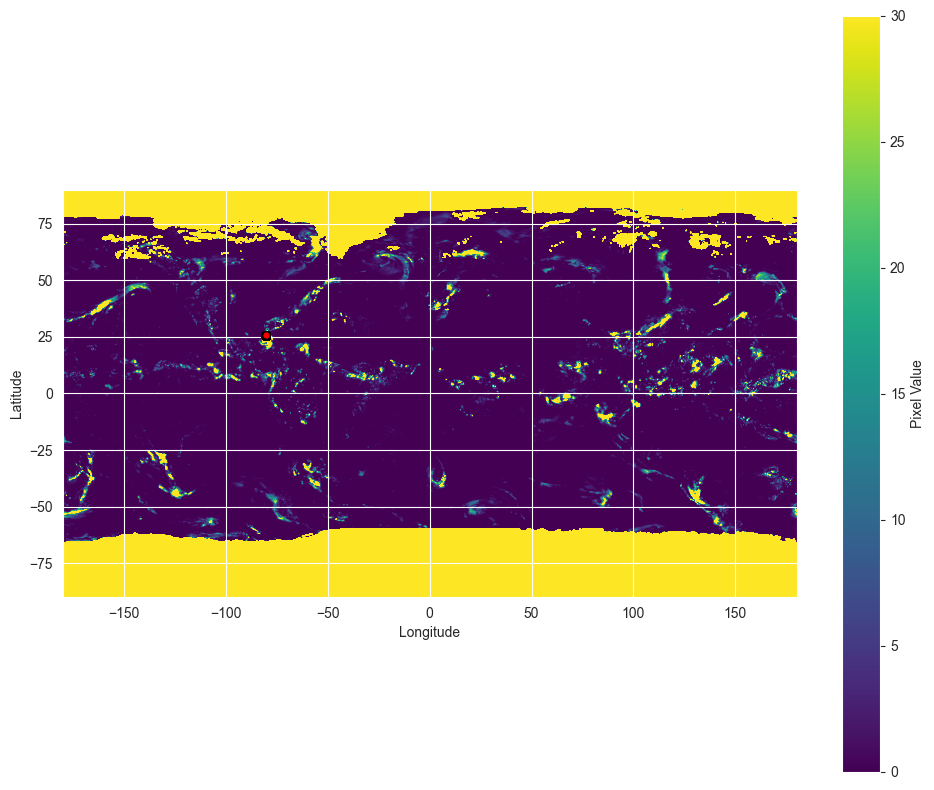

In [308]:
import rasterio
import matplotlib.pyplot as plt
from pathlib import Path

# --- Paths ---
tif_folder = Path("RainData/18aug")
points_fp = "your_points.geojson"  # Update if needed

# --- Load the first .tif file that matches your criteria ---
# all_tifs = sorted(tif_folder.glob("*.tif"))

# Example: just plot the first one
# first_tif = all_tifs[0]

# --- Load raster ---
with rasterio.open(selected_files[0], mode='r+') as src:
    # src.crs = rasterio.crs.CRS({'init': 'epsg:4326'})
    image = src.read(1)
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
    
    # extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

# --- Load and project points ---

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(image, cmap='viridis',extent=extent, origin='upper',vmin=0, vmax=30)
init_df = init_df.to_crs('epsg:4326')
init_df.to_crs("4326").plot(ax=ax, color='red', markersize=30, edgecolor='black')

# plt.title(f"Raster: {first_tif.name}")
plt.colorbar(im, ax=ax, label='Pixel Value')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.show()